<a href="https://colab.research.google.com/github/dkapitan/jads-nhs-proms/blob/master/notebooks/4.0-modeling-clustering-classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Background to osteoarthritis case study

This is day 4 from the [5-day JADS NHS PROMs data science case study](https://github.com/dkapitan/jads-nhs-proms/blob/master/README.md). To recap the previous lectures:

- In **lecture 1** we focused on data understanding and explored various possible outcome parameters.
- In **lecture 2** we constructed a combined outcome parameter using cut-off points for pain and physical functioning.
- In **lecture 3** we performed regression and linear modeling on the outcome paramter `t1_eq_vas`.

Today we are going to focus on classifcation.

# Modeling: clustering & classfication

## Learning objectives
### Modeling: classification

Recall we defined different outcome Y suitable for classification in lecture 2:

- `y_mcid`: outcome is good (True/1) if `t1_oks_score` is above the threshold or `delta_oks_score` is larger than MCID
- `y_t1_pain_good` and `y_t1_functioning_good`: combination of two binary outcomes, yielding a total of 4 classes.

We will use the second outcome since it is more challenging and versatile (see [this presentation (in Dutch)](https://kapitan.net/wp-content/uploads/2018/11/181108_data_driven_healthcare_congres.pdf) for more details):
- perform a binary classification, defining good outcome where both pain and functioning is good at `t1`
- perform multiclass classification.

We will compare the performance of single estimators (SVM, Decision tree) with ensemble learning (Random Forest, Gradient Boosting). Grid search and cross validation is done for model assessment. Some examples are given to visualize scoring functions of models to aid in model selection.


### Python: Hands-on Machine Learning (2nd edition)

- [Classification (chapter 3](https://github.com/ageron/handson-ml2/blob/master/03_classification.ipynb)
- [Support-vector machines (chapter 5)](https://github.com/ageron/handson-ml2/blob/master/05_support_vector_machines.ipynb)
- [Decision trees (chapter 6)](https://github.com/ageron/handson-ml2/blob/master/06_decision_trees.ipynb)
- [Ensemble learning and random forests (chapter 7)](https://github.com/ageron/handson-ml2/blob/master/07_ensemble_learning_and_random_forests.ipynb)

### Ptyon: scikit-learn and matplotlib
- [Demonstration of multi-metric evaluation on cross_val_score and GridSearchCV](https://scikit-learn.org/stable/auto_examples/model_selection/plot_multi_metric_evaluation.html#sphx-glr-auto-examples-model-selection-plot-multi-metric-evaluation-py)
- [Visualizations](https://scikit-learn.org/stable/visualizations.html#visualizations)
- [Real Python Matplotlib guide](https://realpython.com/python-matplotlib-guide/)
- [Matplotlib anatomy](https://matplotlib.org/3.2.2/gallery/showcase/anatomy.html)
- [Yellowbrick](https://www.slideshare.net/RebeccaBilbro/learning-machine-learning-with-yellowbrick)

So let's start by re-running the relevant code from previous lectures.

In [29]:
import warnings
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedShuffleSplit

#supressing warnings for readability
warnings.filterwarnings("ignore")

# To plot pretty figures directly within Jupyter
%matplotlib inline

# choose your own style: https://matplotlib.org/3.1.0/gallery/style_sheets/style_sheets_reference.html
plt.style.use('seaborn-whitegrid')

# Go to town with https://matplotlib.org/tutorials/introductory/customizing.html
# plt.rcParams.keys()
mpl.rc('axes', labelsize=14, titlesize=14)
mpl.rc('figure', titlesize=20)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# contants for figsize
S = (8,8)
M = (12,12)
L = (14,14)

# pandas options
pd.set_option("display.max.columns", None)
pd.set_option("display.max.rows", None)
pd.set_option("display.precision", 2)

# read data
df = pd.read_parquet('https://github.com/dkapitan/jads-nhs-proms/blob/master/data/interim/knee-provider.parquet?raw=true')

In [2]:
# handy function to select oks columns
def oks_questions(t='t0'):
  return [
    col for col in df.columns if col.startswith(f"oks_{t}") and not col.endswith("_score")
]

# replace sentinel values in oks columns
# note we are doing imputation on original dataframe (rather than in pipeline later on)
# so we can perform it prior to StratefiedShuffleSplit
oks_no9 = oks_questions('t0') + oks_questions('t1')
impute_oks = SimpleImputer(missing_values=9, strategy="most_frequent")
df.loc[:, oks_no9] = impute_oks.fit_transform(df[oks_no9])

# group columns t0
age_band = ["age_band"]
gender = ["gender"]
age_band_categories = sorted([x for x in df.age_band.unique() if isinstance(x, str)])
comorb = [
    "heart_disease",
    "high_bp",
    "stroke",
    "circulation",
    "lung_disease",
    "diabetes",
    "kidney_disease",
    "nervous_system",
    "liver_disease",
    "cancer",
    "depression",
    "arthritis",
]
boolean = ["t0_assisted", "t0_previous_surgery", "t0_disability"]
eq5d = ["t0_mobility", "t0_self_care", "t0_activity", "t0_discomfort", "t0_anxiety"]
eq_vas = ["t0_eq_vas"]
categorical = ["t0_symptom_period", "t0_previous_surgery", "t0_living_arrangements"]
oks_score = ["oks_t0_score"]

# add number of comorbidities as extra feature
impute_comorb = SimpleImputer(missing_values=9, strategy="constant", fill_value=0)
df.loc[:, comorb] = impute_comorb.fit_transform(df[comorb])
df["n_comorb"] = df.loc[:, comorb].sum()


# define outcome Y
CUT_OFF_PAIN = 4
CUT_OFF_FUNCTIONING = 26

for t in ("t0", "t1"):
    df[f"oks_{t}_pain_total"] = df[f"oks_{t}_pain"] + df[f"oks_{t}_night_pain"]
    df[f"oks_{t}_functioning_total"] = (
        df.loc[:, [col for col in oks_questions(t) if "pain" not in col]]
        .sum(axis=1)
    )
    df[f"y_{t}_pain_good"] = df[f"oks_{t}_pain_total"].apply(
        lambda s: True if s >= CUT_OFF_PAIN else False
    )
    df[f"y_{t}_functioning_good"] = df[f"oks_{t}_functioning_total"].apply(
        lambda s: True if s >= CUT_OFF_FUNCTIONING else False
    )

# define binary outcome parameter
df["y_binary"] = np.logical_and(df.y_t1_pain_good, df.y_t1_functioning_good)

# Only using 1 split for stratefied sampling, more folds are used later on in cross-validation
split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
for train_index, test_index in split.split(df, df["y_binary"]):
    df_train = df.loc[train_index]
    df_test = df.loc[test_index]
    
y_train_pain_good = df_train.y_t1_pain_good
y_train_pain_good = df_train.y_t1_functioning_good
y_train_binary = df_train.y_binary

In [3]:
pd.crosstab(df_train.y_t0_pain_good, df_train.y_t0_functioning_good, normalize=True)

y_t0_functioning_good,False,True
y_t0_pain_good,,
False,0.81,0.07
True,0.08,0.05


In [4]:
pd.crosstab(df_train.y_t1_pain_good, df_train.y_t1_functioning_good, normalize=True)

y_t1_functioning_good,False,True
y_t1_pain_good,,
False,0.15,0.06
True,0.08,0.71


In [5]:
# same pipeline as lecture 3
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer


# preprocessing pipelines for specific columns
age_band_pipe = Pipeline(
    steps=[
        ("impute", SimpleImputer(missing_values=np.nan, strategy="most_frequent")),
        ("ordinal", OrdinalEncoder(categories=[age_band_categories])),
    ]
)
gender_pipe = Pipeline(
    steps=[
        ("impute", SimpleImputer(missing_values=np.nan, strategy="most_frequent")),
        ("onehot", OneHotEncoder()),
    ]
)

# ColumnTransformer on all included columns.
# Note columns that are not specified are dropped by default
transformers = {
    "age": ("age", age_band_pipe, age_band),
    "gender": ("gender", gender_pipe, gender),
    "comorb": (
        "comorb",
        'passthrough',
        comorb,
    ),
    "categorical": (
        "categorical",
        SimpleImputer(missing_values=9, strategy="most_frequent"),
        boolean + eq5d + categorical,
    ),
    "oks": (
        "oks",
        'passthrough',
        oks_questions('t0'),
    ),
    "eq_vas": ("eqvas", SimpleImputer(missing_values=999, strategy="median"), eq_vas),
}
prep = ColumnTransformer(
    transformers=[v for _, v in transformers.items()])

# X_train = prep.fit_transform(df_train)
# X_test = prep.fit_transform(df_test)

# list of columns for convenience
# https://stackoverflow.com/questions/54646709/sklearn-pipeline-get-feature-name-after-onehotencode-in-columntransformer
# X_columns = pd.Series(
#     age_band
#     + prep.named_transformers_["gender"]["onehot"].get_feature_names().tolist()
#     + comorb
#     + boolean
#     + eq5d
#     + categorical
#     + oks_questions('t0')
#     + oks_score
#     + eq_vas
# )

## Classification

### Single estimators
#### Stochastic Gradient Descent

In [6]:
%%time
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score


sgd = Pipeline(
    steps=[("prep", prep), ("sgd", SGDClassifier(loss="hinge", penalty="l2", tol=1e-3))]
)

# https://scikit-learn.org/stable/tutorial/statistical_inference/putting_together.html
sgd_parameters = {"sgd__max_iter": [10]} #, 100, 1000]}

sgd_search = GridSearchCV(sgd, sgd_parameters, cv=5)
sgd_search.fit(df_train, y_train_binary);

CPU times: user 9.69 s, sys: 774 ms, total: 10.5 s
Wall time: 9.07 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('age',
                                                                         Pipeline(steps=[('impute',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ordinal',
                                                                                          OrdinalEncoder(categories=[['40 '
                                                                                                                      'to '
                                                                                                                      '49',
                                                                                                                      '50 '
                        

In [7]:
confusion_matrix(y_train_binary, sgd_search.best_estimator_.predict(df_train), normalize='all')

array([[0.17532448, 0.11733443],
       [0.2265839 , 0.48075719]])

In [8]:
cross_val_score(sgd_search.best_estimator_, df_train, y_train_binary, cv=3, scoring="roc_auc")

array([0.69061227, 0.68671459, 0.70017077])

#### Decision tree

In [9]:
%%time
from sklearn.tree import DecisionTreeClassifier

cart = Pipeline(
    steps=[
        ("prep", prep),
        ("cart", DecisionTreeClassifier()),
    ]
)

cart_parameters = {
'cart__max_depth': [10, 30],
'cart__min_samples_leaf': [0.02, 0.05, 0.1, 0.2],
}

cart_search = GridSearchCV(cart, cart_parameters, cv=5)
cart_search.fit(df_train, y_train_binary);

CPU times: user 56.8 s, sys: 4.15 s, total: 1min
Wall time: 1min 1s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('age',
                                                                         Pipeline(steps=[('impute',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ordinal',
                                                                                          OrdinalEncoder(categories=[['40 '
                                                                                                                      'to '
                                                                                                                      '49',
                                                                                                                      '50 '
                        

In [10]:
confusion_matrix(y_train_binary, cart_search.best_estimator_.predict(df_train), normalize='all')

array([[0.05869799, 0.23396091],
       [0.03967578, 0.66766532]])

In [11]:
cross_val_score(cart_search.best_estimator_, df_train, y_train_binary, cv=3, scoring="roc_auc")

array([0.68623186, 0.68977625, 0.68147539])

#### LinearSVC  

In [12]:
%%time
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

svm = Pipeline(
    steps=[
        ("prep", prep),
        ("scaler", StandardScaler()),
        ("clf", LinearSVC(C=1, loss="hinge")),
    ]
)
svm.fit(df_train, y_train_binary);

CPU times: user 21.4 s, sys: 206 ms, total: 21.7 s
Wall time: 21.7 s


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('age',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder(categories=[['40 '
                                                                                               'to '
                                                                                               '49',
                                                                                               '50 '
                                                                                               'to '
                                                                                               '59',
                                                

In [13]:
confusion_matrix(y_train_binary, svm.predict(df_train), normalize='all')

array([[0.02813318, 0.26452573],
       [0.02801005, 0.67933104]])

In [14]:
cross_val_score(svm, df_train, y_train_binary, cv=3, scoring="roc_auc")

array([0.54497742, 0.59003644, 0.52160876])

#### ROC curve
It is more intuitive to compare different estimators visually, i.e. visualizing the performance metrics. scikit-learn 0.22 comes with a [new plotting API](https://scikit-learn.org/stable/auto_examples/release_highlights/plot_release_highlights_0_22_0.html#sphx-glr-auto-examples-release-highlights-plot-release-highlights-0-22-0-py), so it's much easier than before to quickly produce charts. We start with the good ol' ROC curve (although later on I will stress not to use this!).

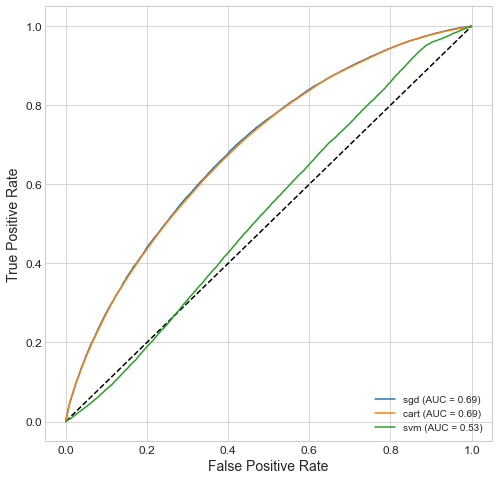

In [15]:
from sklearn.metrics import plot_roc_curve, plot_precision_recall_curve

clfs = {
    "sgd": sgd_search.best_estimator_,
    "cart": cart_search.best_estimator_,
    "svm": svm,
}

fig_roc, ax_roc = plt.subplots(figsize=S)
plt.plot([0, 1], [0, 1], 'k--')
for k,v in clfs.items():
    plot_roc_curve(v, df_train, y_train_binary, name=k, ax=ax_roc)

This is not very exciting at all. Let's look at the precision recall curve (which probably is even worse).

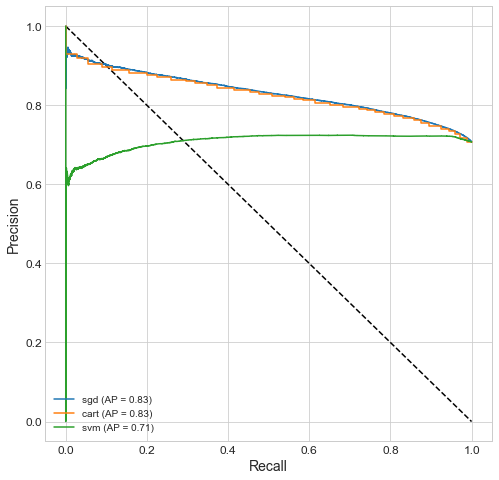

In [16]:
fig_prc, ax_prc = plt.subplots(figsize=S)
plt.plot([0, 1], [1, 0], 'k--')
for k,v in clfs.items():
    plot_precision_recall_curve(v, df_train, y_train_binary, name=k, ax=ax_prc)

### Ensemble methods: Random Forest & GradientBoosted Trees

We are going to do the same - train classifiers with grid search and cross-validation - but using an ensemble of learners this time.

In [17]:
%%time
from sklearn.ensemble import RandomForestClassifier


rf = Pipeline(
    steps=[("prep", prep), ("rf", RandomForestClassifier(random_state=42, n_jobs=-1))]
)
rf_parameters = {
    "rf__max_samples": [1000],  # don't use the whole dataset: takes too long!
    "rf__n_estimators": [100],
    "rf__criterion": ["gini"],
    "rf__max_features": ["auto"],
    "rf__min_samples_leaf": [1, 2, 5],
    "rf__max_depth": [10, 15],
    "rf__oob_score": [True, False],
}
rf_search = GridSearchCV(rf, rf_parameters, cv=5)
rf_search.fit(df_train, y_train_binary)

CPU times: user 2min 18s, sys: 11.7 s, total: 2min 30s
Wall time: 2min 36s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('age',
                                                                         Pipeline(steps=[('impute',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ordinal',
                                                                                          OrdinalEncoder(categories=[['40 '
                                                                                                                      'to '
                                                                                                                      '49',
                                                                                                                      '50 '
                        

In [18]:
%%time
from sklearn.ensemble import GradientBoostingClassifier

gb = Pipeline(
    steps=[("prep", prep), ("gb", GradientBoostingClassifier())]
)
gb_parameters = {
    "gb__learning_rate": 1.0,
    "gb__n_estimators": [100, 200],
    "gb__min_samples_leaf": [1, 2, 5],
    "gb__max_features": ["auto"],
    "gb__max_depth": [2, 3, 5],
}
gb_search = GridSearchCV(rf, rf_parameters, cv=5)
gb_search.fit(df_train, y_train_binary)

CPU times: user 2min 16s, sys: 11.2 s, total: 2min 27s
Wall time: 2min 31s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('age',
                                                                         Pipeline(steps=[('impute',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ordinal',
                                                                                          OrdinalEncoder(categories=[['40 '
                                                                                                                      'to '
                                                                                                                      '49',
                                                                                                                      '50 '
                        

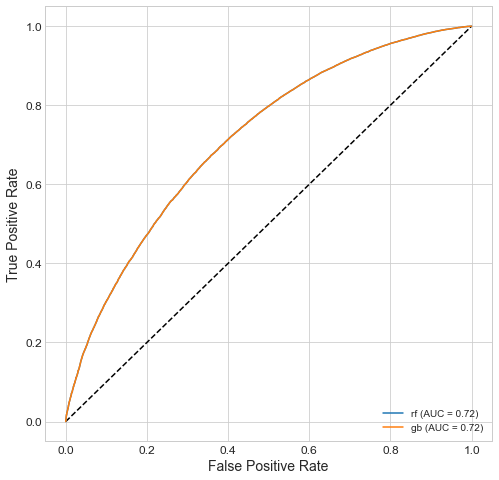

In [19]:
ensembles = {
    "rf": rf_search.best_estimator_,
    "gb": gb_search.best_estimator_,
}

fig_roc2, ax_roc2 = plt.subplots(figsize=S)
plt.plot([0, 1], [0, 1], 'k--')
for k,v in ensembles.items():
    plot_roc_curve(v, df_train, y_train_binary, name=k, ax=ax_roc2)

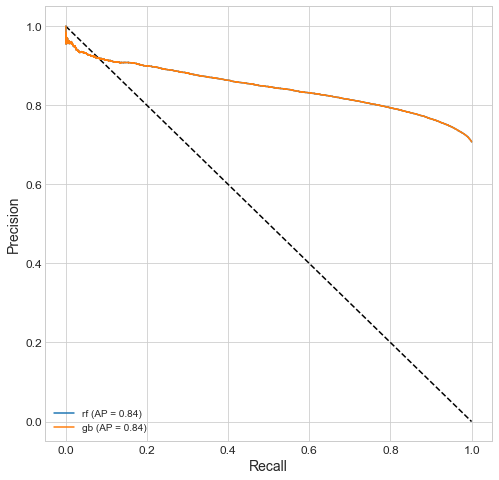

In [20]:
fig_prc2, ax_prc2 = plt.subplots(figsize=S)
plt.plot([0, 1], [1, 0], 'k--')
for k,v in ensembles.items():
    plot_precision_recall_curve(v, df_train, y_train_binary, name=k, ax=ax_prc2)

#### Ensemble methods: balanced
The results are still not very satisfying. We will try balanced Random Forest, using the `class_weight` option in scikit-learn and comparing that next to the `BalancedRandomForestClassifier` from the [imbalanced-learn](https://imbalanced-learn.readthedocs.io/en/stable/) package.

In [21]:
%%time
from sklearn.ensemble import RandomForestClassifier


brf = Pipeline(
    steps=[("prep", prep), ("brf", RandomForestClassifier(random_state=42, n_jobs=-1))]
)
brf_parameters = {
    "rf__max_samples": [1000],  # don't use the whole dataset: takes too long!
    "rf__n_estimators": [100],
    "rf__criterion": ["gini"],
    "rf__max_features": ["auto"],
    "rf__min_samples_leaf": [1, 2, 5],
    "rf__max_depth": [10, 15],
    "rf__oob_score": [True, False],
    "rf__class_weight": ["balanced"],
}
brf_search = GridSearchCV(rf, brf_parameters, cv=5)
brf_search.fit(df_train, y_train_binary)

CPU times: user 2min 17s, sys: 10.9 s, total: 2min 28s
Wall time: 2min 38s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('age',
                                                                         Pipeline(steps=[('impute',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ordinal',
                                                                                          OrdinalEncoder(categories=[['40 '
                                                                                                                      'to '
                                                                                                                      '49',
                                                                                                                      '50 '
                        

In [22]:
%%time
from imblearn.ensemble import BalancedRandomForestClassifier


ibrf = Pipeline(
    steps=[("prep", prep), ("ibrf", BalancedRandomForestClassifier(random_state=42, n_jobs=-1))]
)
ibrf_parameters = {
    "rf__max_samples": [1000],  # don't use the whole dataset: takes too long!
    "rf__n_estimators": [100],
    "rf__criterion": ["gini"],
    "rf__max_features": ["auto"],
    "rf__min_samples_leaf": [1, 2, 5],
    "rf__max_depth": [10, 15],
    "rf__oob_score": [True, False],
    "rf__class_weight": ["balanced"],
}
ibrf_search = GridSearchCV(rf, ibrf_parameters, cv=5)
ibrf_search.fit(df_train, y_train_binary)

CPU times: user 2min 22s, sys: 12 s, total: 2min 34s
Wall time: 2min 50s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('age',
                                                                         Pipeline(steps=[('impute',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ordinal',
                                                                                          OrdinalEncoder(categories=[['40 '
                                                                                                                      'to '
                                                                                                                      '49',
                                                                                                                      '50 '
                        

In [23]:
y_train_binary_inverted = np.invert(y_train_binary)
ibrf2 = Pipeline(
    steps=[("prep", prep), ("ibrf", BalancedRandomForestClassifier(random_state=42, n_jobs=-1))]
)
ibrf_parameters2 = {
    "rf__max_samples": [1000],  # don't use the whole dataset: takes too long!
    "rf__n_estimators": [100],
    "rf__criterion": ["gini"],
    "rf__max_features": ["auto"],
    "rf__min_samples_leaf": [1, 2, 5],
    "rf__max_depth": [10, 15],
    "rf__oob_score": [True, False],
    "rf__class_weight": ["balanced"],
}
ibrf_search2 = GridSearchCV(rf, ibrf_parameters2, cv=5)
ibrf_search2.fit(df_train, y_train_binary_inverted)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('age',
                                                                         Pipeline(steps=[('impute',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ordinal',
                                                                                          OrdinalEncoder(categories=[['40 '
                                                                                                                      'to '
                                                                                                                      '49',
                                                                                                                      '50 '
                        

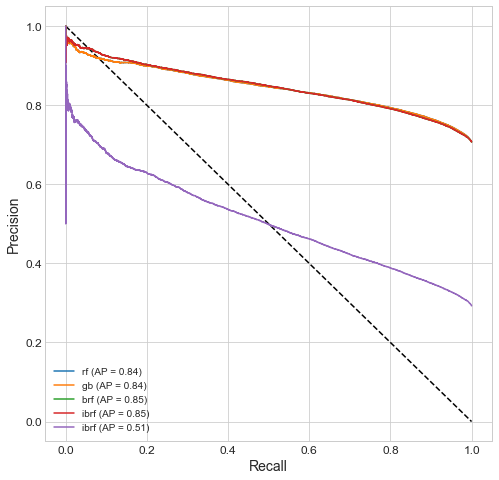

In [24]:
ensembles["brf"] = brf_search.best_estimator_
ensembles["ibrf"] = ibrf_search.best_estimator_
# ensembles["ibrf2"] = ibrf_search2.best_estimator_
fig_prc3, ax_prc3 = plt.subplots(figsize=S)
plt.plot([0, 1], [1, 0], 'k--')
for k,v in ensembles.items():
    plot_precision_recall_curve(v, df_train, y_train_binary, name=k, ax=ax_prc3)
plot_precision_recall_curve(ibrf_search2.best_estimator_, df_train, y_train_binary_inverted, name=k, ax=ax_prc3)

#### Bonus: Yellowbrick
To further optimze your workflow, you can use [Yellowbrick](https://www.scikit-yb.org/en/latest/index.html) for visualizing results.

No handles with labels found to put in legend.


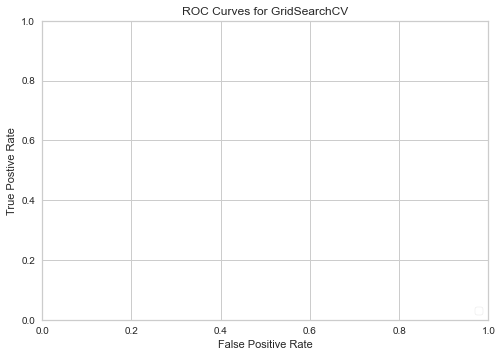

<AxesSubplot:title={'center':'ROC Curves for GridSearchCV'}, xlabel='False Positive Rate', ylabel='True Postive Rate'>

In [25]:
from yellowbrick.classifier import ROCAUC, PrecisionRecallCurve

roc = ROCAUC(sgd_search)
roc.fit(df_train, y_train_binary)
roc.show()     

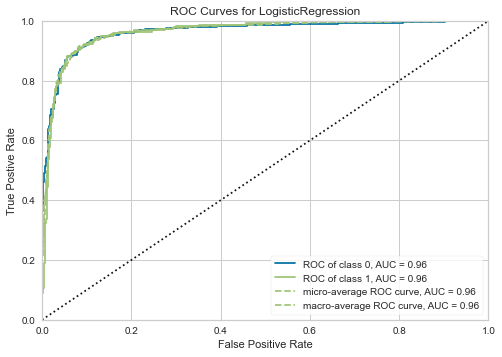

<AxesSubplot:title={'center':'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Postive Rate'>

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from yellowbrick.classifier import ROCAUC
from yellowbrick.datasets import load_spam

# Load the classification dataset
X, y = load_spam()

# Create the training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Instantiate the visualizer with the classification model
model = LogisticRegression(multi_class="auto", solver="liblinear")
visualizer = ROCAUC(model,)

visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()                       # Finalize and show the figure

In [27]:
# TO DO: sklearn-autoML

## Model assessment

* ...
* ...

In [28]:
# TO DO: Feature importance

### Checklist for results from modeling process
* ...
* ...